## Genre Genie - Multi-label Classification with NLP
### Part 3.1: Modeling using OneVsRest

#### Tom Keith

---

**Goal:** Fit and optimize multi-label classification model on the train set. Finally, score on test set.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
%matplotlib inline
import joblib

Import train and test dataframes from previous step. They are large files.

In [2]:
%%time
train = pd.read_csv('data/train_dataframe.tsv', sep='\t', index_col=0)
test = pd.read_csv('data/test_dataframe.tsv', sep='\t', index_col=0)

Wall time: 29.3 s


Put the genre and features names (which aren't words) into lists for easy use.

In [3]:
cols = list(train.columns.values)
genre_cols = cols[-22:]
print(len(genre_cols))
print(genre_cols)

22
['g_action', 'g_adventure', 'g_animation', 'g_biography', 'g_comedy', 'g_crime', 'g_documentary', 'g_drama', 'g_family', 'g_fantasy', 'g_film-noir', 'g_history', 'g_horror', 'g_music', 'g_musical', 'g_mystery', 'g_romance', 'g_sci-fi', 'g_sport', 'g_thriller', 'g_war', 'g_western']


In [4]:
f_names = cols[:8]

Separate out X and y out of our train and test .tsv files. We want JUST the genre columns for `y` and everything except the genre columns for `X`.

In [5]:
X_train = train[train.columns[~train.columns.isin(genre_cols)]]
y_train = train[train.columns[ train.columns.isin(genre_cols)]]

X_test = test[test.columns[~test.columns.isin(genre_cols)]]
y_test = test[test.columns[ test.columns.isin(genre_cols)]]

---

Before running a model, we need to scale our data. Both standard and min-max were tested, but standard scaler came out on top.

In [8]:
%%time
# Scale data (Standard Scaler)
from sklearn.preprocessing import StandardScaler 
my_standard_scaler = StandardScaler().fit(X_train)
X_train_s = my_standard_scaler.transform(X_train)
X_test_s = my_standard_scaler.transform(X_test)

#joblib.dump(my_standard_scaler, 'models/my_standard_scaler.pkl')

In [98]:
# Scale data (MinMax Scaler)
from sklearn.preprocessing import MinMaxScaler 
my_minmax_scaler = MinMaxScaler().fit(X_train)
X_train_mm = my_minmax_scaler.transform(X_train)
X_test_mm = my_minmax_scaler.transform(X_test)

#joblib.dump(my_minmax_scaler, 'models/my_minmax_scaler.pkl')

['models/my_minmax_scaler.pkl']

---

### Please note
MANY models were tested and pkl'd. Below is the optimized model. After that, everything below it is testing of other models, scalers, score grading, and tuning hyperparameters. I normally would not include all of them, but they remain for completeness.

In the end, OneVsRest with Logistic Regression (C=0.01, solver='lbfgs') when scaled with a standard scaler was the best option.

In [10]:
import joblib
#my_model = joblib.load('models/my_1vr_linear_svc_default.pkl')

In [9]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [113]:
from sklearn.model_selection import cross_val_score
my_log_model = OneVsRestClassifier(LogisticRegression(random_state=123, solver='lbfgs', max_iter=3000, C=0.01, n_jobs=-1), n_jobs=-1)

scores = cross_val_score(my_log_model, X_train_s, y_train, cv = 5)
print(scores)

for i in range(len(scores)) :
    print(f"Fold {i+1}: {scores[i]}")
print(f"Average Score:{np.mean(scores)}")

[0.09696028 0.08988016 0.09786951 0.09476254 0.09476254]
Fold 1: 0.09696028400266253
Fold 2: 0.08988015978695073
Fold 3: 0.09786950732356857
Fold 4: 0.09476253883710609
Fold 5: 0.09476253883710609
Average Score:0.0948470057574788


In [10]:
%%time
my_log_model = OneVsRestClassifier(LogisticRegression(random_state=123, solver='lbfgs', max_iter=3000, C=0.01, n_jobs=-1), n_jobs=-1).fit(X_train_s, y_train)

Wall time: 59.2 s


In [11]:
y_train_pred = my_log_model.predict(X_train_s)
y_train_proba = my_log_model.predict_proba(X_train_s)
y_test_pred = my_log_model.predict(X_test_s)
y_test_proba = my_log_model.predict_proba(X_test_s)

In [13]:
from sklearn.metrics import accuracy_score
print(f'Training score: {accuracy_score(y_train, y_train_pred):0.5f}')
print(f'    Test score: {accuracy_score(y_test, y_test_pred):0.5f}')

Training score: 0.54290
    Test score: 0.10558


In [16]:
y_pred_df = pd.DataFrame(y_test_pred, columns=genre_cols)

# Test set predictions
for g in genre_cols:
    score = accuracy_score(y_test[g], y_pred_df[g])
    print(f'{score:0.4f}  {g}')

0.8350  g_action
0.8771  g_adventure
0.9703  g_animation
0.9397  g_biography
0.7344  g_comedy
0.8410  g_crime
0.9730  g_documentary
0.6931  g_drama
0.9318  g_family
0.9140  g_fantasy
0.9892  g_film-noir
0.9506  g_history
0.9116  g_horror
0.9384  g_music
0.9657  g_musical
0.8823  g_mystery
0.7822  g_romance
0.9369  g_sci-fi
0.9794  g_sport
0.7769  g_thriller
0.9611  g_war
0.9867  g_western



---

## Everything below is model testing and optimizing

In [79]:
%%time
#my_model = OneVsRestClassifier(LinearSVC(random_state=123, max_iter=3000), n_jobs=-1).fit(X_train_s, y_train)

Wall time: 22min 6s


In [92]:
# EXPORT AND SAVE THE MODEL
#joblib.dump(my_model, 'models/my_1vr_linear_svc_default.pkl')

C:\Users\Tom\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['models/my_1vr_linear_svc_default.pkl']

In [ ]:
y_pred = my_model.predict(X_test_s)

In [12]:
y_train_pred = my_model.predict(X_train_s)

In [13]:
my_model.multilabel_
#my_model.predict_proba(X_train_s)

True

In [90]:
from sklearn.metrics import accuracy_score
print(f'Training score: {accuracy_score(y_train, y_train_pred):0.5f}')
print(f'    Test score: {accuracy_score(y_test, y_pred):0.5f}')

Training score: 0.49665
    Test score: 0.04367


In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix

In [67]:
# Confusion Matrix
cm = multilabel_confusion_matrix(y_test, y_pred)

g_cm_list = []
for g in cm:
    g_cm_list.append(pd.DataFrame(g, columns=['Predicted Negative (0)', 'Predicted Positive (1)'], \
                 index=['True Negative (0)','True Positive (1)']))
    
g_cm_list[10].values

array([[7360,   70],
       [  63,   18]], dtype=int64)

In [86]:
y_train_pred_df = pd.DataFrame(y_train_pred)
y_train_pred_df.columns = genre_cols
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.columns = genre_cols

In [17]:
test_acc_dict = {}
# Test set predictions
for g in genre_cols:
    score = accuracy_score(y_test[g], y_pred_df[g])
    test_acc_dict.update( {g[2:] : score} )
    print(f'{score:0.4f}  {g}')

0.8350  g_action
0.8771  g_adventure
0.9703  g_animation
0.9397  g_biography
0.7344  g_comedy
0.8410  g_crime
0.9730  g_documentary
0.6931  g_drama
0.9318  g_family
0.9140  g_fantasy
0.9892  g_film-noir
0.9506  g_history
0.9116  g_horror
0.9384  g_music
0.9657  g_musical
0.8823  g_mystery
0.7822  g_romance
0.9369  g_sci-fi
0.9794  g_sport
0.7769  g_thriller
0.9611  g_war
0.9867  g_western


In [18]:
test_scores = pd.DataFrame.from_dict(test_acc_dict, orient='index', columns=['score'])

In [19]:
test_scores.to_csv('test_scores_last_model.csv', index_label='genre')

In [22]:
coefs = my_model.coef_

In [75]:
coef_df = pd.DataFrame(coefs, index=genre_cols, columns=X_train.columns)
coef_tdf = coef_df.T
coef_tdf

,g_action,g_adventure,g_animation,g_biography,g_comedy,g_crime,g_documentary,g_drama,g_family,g_fantasy,g_film-noir,g_history,g_horror,g_music,g_musical,g_mystery,g_romance,g_sci-fi,g_sport,g_thriller,g_war,g_western
f_release_year,0.890920,-0.202585,0.205493,0.156150,0.090189,0.207143,0.112173,-0.024676,-0.005681,0.000552,-0.192294,0.262658,-0.124317,-0.247146,-0.202726,-0.000374,-0.163564,-0.082269,-0.013732,0.092245,0.168980,0.168377
f_release_month,0.162641,0.093539,0.032958,-0.002919,-0.007082,-0.054702,-0.018309,0.026233,0.056573,0.120411,0.000712,-0.090634,-0.025620,0.030871,0.001300,0.005833,0.013643,0.013330,-0.010611,0.009509,-0.108588,-0.121271
f_runtime,0.997796,0.052923,-0.329772,0.151680,-0.136051,-0.098478,-0.125171,0.161513,-0.157185,-0.139964,-0.046469,0.234240,-0.372855,0.120316,0.074502,0.034689,0.109954,-0.061331,0.012625,0.053091,0.236038,0.229005
f_word_count_long,0.221205,0.002507,0.022708,0.008983,-0.089621,-0.157927,0.015894,-0.003234,0.103574,0.235768,0.010266,0.010166,-0.077899,0.029570,0.042731,0.011146,-0.027546,0.017361,0.024619,0.003008,-0.013937,-0.003826
f_imdb_rating,-0.992456,-0.122722,0.277040,0.168530,-0.071904,1.286002,0.241488,0.239085,0.045930,0.015202,0.052162,0.150826,-0.554526,0.047041,0.012359,0.118412,-0.026726,-0.234360,0.013724,-0.086579,0.051071,0.007038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zealand,0.201899,-0.011669,-0.000164,0.038771,-0.038884,-0.200695,0.013058,0.013915,0.007938,0.020752,-0.001004,-0.008869,-0.048644,0.001566,-0.016636,-0.099761,0.006259,-0.014353,0.009601,0.003707,0.014746,0.001099
zero,0.145570,-0.053593,0.022223,0.015668,0.019288,-0.090709,-0.003745,0.002425,-0.020840,0.058833,0.003737,0.005958,-0.093422,0.027760,0.030987,0.093844,0.031099,0.011547,0.006995,0.014213,0.008819,0.001835
zombi,-0.028788,-0.057147,-0.007456,0.005884,0.020771,-0.279043,-0.000784,-0.027079,-0.005703,-0.038465,0.003023,-0.020218,0.341943,0.012054,0.030725,-0.135719,-0.007812,0.022717,-0.009578,0.004558,-0.052168,-0.011931
zone,0.188484,0.066910,-0.011633,-0.034049,0.013658,-0.053566,0.012062,-0.014565,-0.003714,0.043539,-0.001000,0.025871,-0.015155,0.039160,-0.007195,-0.075479,-0.015189,0.036640,-0.033840,-0.004590,0.025977,-0.003066


In [29]:
coef_tdf.to_csv('my_1vr_linear_svc_default_coef.tsv', sep='\t')

In [69]:
%%time
my_log_model = OneVsRestClassifier(LogisticRegression(random_state=123, max_iter=3000), n_jobs=-1).fit(X_train_s, y_train)

# EXPORT AND SAVE THE MODEL
joblib.dump(my_log_model, 'models/my_1vr_logreg_default.pkl')

Wall time: 8min 26s


['models/my_1vr_logreg_default.pkl']

In [106]:
%%time
my_log_model_mm = OneVsRestClassifier(LogisticRegression(random_state=123, max_iter=3000, C=0.01), n_jobs=-1).fit(X_train_mm, y_train)

# EXPORT AND SAVE THE MODEL
joblib.dump(my_log_model_mm, 'models/my_1vr_logreg_minmax_0.01.pkl')

Wall time: 11 s


['models/my_1vr_logreg_minmax_0.01.pkl']

In [109]:
y_pred_log_mm = my_log_model_mm.predict(X_test_mm)
y_train_pred_log_mm = my_log_model_mm.predict(X_train_mm)
from sklearn.metrics import accuracy_score
print(f'Train: {accuracy_score(y_train, y_train_pred_log_mm)}')
print(f' Test: {accuracy_score(y_test, y_pred_log)}')

y_train_pred_log_mm_df = pd.DataFrame(y_train_pred_log_mm)
y_train_pred_log_mm_df.columns = genre_cols

y_pred_log_mm_df = pd.DataFrame(y_pred_log_mm)
y_pred_log_mm_df.columns = genre_cols

#test_acc_dict = {}
# Test set predictions
for g in genre_cols:
    score = accuracy_score(y_test[g], y_pred_log_mm_df[g])
    #test_acc_dict.update( {g[2:] : score} )
    print(f'{score:0.4f}  {g}')

Train: 0.08490524166703653
 Test: 0.07189455465317535
0.8136  g_action
0.8852  g_adventure
0.9691  g_animation
0.9478  g_biography
0.6686  g_comedy
0.8396  g_crime
0.9525  g_documentary
0.6873  g_drama
0.9406  g_family
0.9249  g_fantasy
0.9892  g_film-noir
0.9561  g_history
0.8645  g_horror
0.9342  g_music
0.9698  g_musical
0.9087  g_mystery
0.7774  g_romance
0.9179  g_sci-fi
0.9708  g_sport
0.7594  g_thriller
0.9490  g_war
0.9775  g_western


In [101]:
y_pred_log = my_log_model.predict(X_test_s)

In [71]:
y_train_pred_log = my_log_model.predict(X_train_s)

In [72]:
my_log_model.multilabel_
#my_model.predict_proba(X_train_s)

True

In [73]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_train_pred_log)

0.622076250499312

In [80]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_log)

0.06403940886699508

In [81]:
y_train_pred_log_df = pd.DataFrame(y_train_pred_log)
y_train_pred_log_df.columns = genre_cols

y_pred_log_df = pd.DataFrame(y_pred_log)
y_pred_log_df.columns = genre_cols

In [82]:
test_acc_dict = {}
# Test set predictions
for g in genre_cols:
    score = accuracy_score(y_test[g], y_pred_log_df[g])
    test_acc_dict.update( {g[2:] : score} )
    print(f'{score:0.4f}  {g}')

0.7809  g_action
0.8340  g_adventure
0.9561  g_animation
0.9081  g_biography
0.7252  g_comedy
0.7891  g_crime
0.9686  g_documentary
0.6874  g_drama
0.8992  g_family
0.8768  g_fantasy
0.9874  g_film-noir
0.9217  g_history
0.8882  g_horror
0.9101  g_music
0.9449  g_musical
0.8338  g_mystery
0.7617  g_romance
0.9103  g_sci-fi
0.9767  g_sport
0.7566  g_thriller
0.9451  g_war
0.9840  g_western


In [83]:
test_scores_log = pd.DataFrame.from_dict(test_acc_dict, orient='index', columns=['score'])

In [84]:
test_scores_log.to_csv('test_scores_model1.csv', index_label='genre')

In [85]:
coef_df = pd.DataFrame(coefs, index=genre_cols, columns=X_train.columns)
coef_tdf = coef_df.T
coef_tdf

,g_action,g_adventure,g_animation,g_biography,g_comedy,g_crime,g_documentary,g_drama,g_family,g_fantasy,g_film-noir,g_history,g_horror,g_music,g_musical,g_mystery,g_romance,g_sci-fi,g_sport,g_thriller,g_war,g_western
f_release_year,0.890920,-0.202585,0.205493,0.156150,0.090189,0.207143,0.112173,-0.024676,-0.005681,0.000552,-0.192294,0.262658,-0.124317,-0.247146,-0.202726,-0.000374,-0.163564,-0.082269,-0.013732,0.092245,0.168980,0.168377
f_release_month,0.162641,0.093539,0.032958,-0.002919,-0.007082,-0.054702,-0.018309,0.026233,0.056573,0.120411,0.000712,-0.090634,-0.025620,0.030871,0.001300,0.005833,0.013643,0.013330,-0.010611,0.009509,-0.108588,-0.121271
f_runtime,0.997796,0.052923,-0.329772,0.151680,-0.136051,-0.098478,-0.125171,0.161513,-0.157185,-0.139964,-0.046469,0.234240,-0.372855,0.120316,0.074502,0.034689,0.109954,-0.061331,0.012625,0.053091,0.236038,0.229005
f_word_count_long,0.221205,0.002507,0.022708,0.008983,-0.089621,-0.157927,0.015894,-0.003234,0.103574,0.235768,0.010266,0.010166,-0.077899,0.029570,0.042731,0.011146,-0.027546,0.017361,0.024619,0.003008,-0.013937,-0.003826
f_imdb_rating,-0.992456,-0.122722,0.277040,0.168530,-0.071904,1.286002,0.241488,0.239085,0.045930,0.015202,0.052162,0.150826,-0.554526,0.047041,0.012359,0.118412,-0.026726,-0.234360,0.013724,-0.086579,0.051071,0.007038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zealand,0.201899,-0.011669,-0.000164,0.038771,-0.038884,-0.200695,0.013058,0.013915,0.007938,0.020752,-0.001004,-0.008869,-0.048644,0.001566,-0.016636,-0.099761,0.006259,-0.014353,0.009601,0.003707,0.014746,0.001099
zero,0.145570,-0.053593,0.022223,0.015668,0.019288,-0.090709,-0.003745,0.002425,-0.020840,0.058833,0.003737,0.005958,-0.093422,0.027760,0.030987,0.093844,0.031099,0.011547,0.006995,0.014213,0.008819,0.001835
zombi,-0.028788,-0.057147,-0.007456,0.005884,0.020771,-0.279043,-0.000784,-0.027079,-0.005703,-0.038465,0.003023,-0.020218,0.341943,0.012054,0.030725,-0.135719,-0.007812,0.022717,-0.009578,0.004558,-0.052168,-0.011931
zone,0.188484,0.066910,-0.011633,-0.034049,0.013658,-0.053566,0.012062,-0.014565,-0.003714,0.043539,-0.001000,0.025871,-0.015155,0.039160,-0.007195,-0.075479,-0.015189,0.036640,-0.033840,-0.004590,0.025977,-0.003066


In [ ]:
coef_tdf.to_csv('my_1vr_logreg_default_coef.tsv', sep='\t')

In [95]:
%%time

c_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
train_scores = []
test_scores = []

for c_val in c_values:
    my_log_model = OneVsRestClassifier(LogisticRegression(random_state=123, solver='sag', max_iter=3000, C=c_val, n_jobs=-1), n_jobs=-1).fit(X_train_s, y_train)

    # EXPORT AND SAVE THE MODEL
    joblib.dump(my_log_model, f'models/my_1vr_logreg_sag_{c_val}.pkl')
    
    # Make predictions
    y_train_pred_log = my_log_model.predict(X_train_s)
    y_pred_log = my_log_model.predict(X_test_s)

    #my_log_model.multilabel_
    #my_model.predict_proba(X_train_s)
    
    # Check overall accuracies
    from sklearn.metrics import accuracy_score
    train_acc = accuracy_score(y_train, y_train_pred_log)
    test_acc = accuracy_score(y_test, y_pred_log)
    train_scores.append(train_acc)
    test_scores.append(test_acc)
    print(f'C:  {c_val}')
    print(f'Train score: {train_acc:0.5f}')
    print(f' Test score: {test_acc:0.5f}')

    y_train_pred_log_df = pd.DataFrame(y_train_pred_log)
    y_train_pred_log_df.columns = genre_cols

    y_pred_log_df = pd.DataFrame(y_pred_log)
    y_pred_log_df.columns = genre_cols

    test_acc_dict = {}
    # Test genre set predictions
    for g in genre_cols:
        score = accuracy_score(y_test[g], y_pred_log_df[g])
        test_acc_dict.update( {g[2:] : score} )
        print(f'{score:0.4f}  {g}')

    # Export genre scores
    test_scores_log = pd.DataFrame.from_dict(test_acc_dict, orient='index', columns=['score'])
    test_scores_log.to_csv(f'test_scores_logreg_sag_{c_val}.csv', index_label='genre')

C:  1e-05
Train score: 0.07767
 Test score: 0.07150
0.8131  g_action
0.8852  g_adventure
0.9691  g_animation
0.9478  g_biography
0.6407  g_comedy
0.8392  g_crime
0.9525  g_documentary
0.6377  g_drama
0.9406  g_family
0.9249  g_fantasy
0.9892  g_film-noir
0.9561  g_history
0.8643  g_horror
0.9342  g_music
0.9698  g_musical
0.9087  g_mystery
0.7738  g_romance
0.9179  g_sci-fi
0.9708  g_sport
0.7542  g_thriller
0.9489  g_war
0.9775  g_western
C:  0.0001
Train score: 0.17256
 Test score: 0.12355
0.8506  g_action
0.8946  g_adventure
0.9691  g_animation
0.9478  g_biography
0.7606  g_comedy
0.8627  g_crime
0.9558  g_documentary
0.7239  g_drama
0.9409  g_family
0.9282  g_fantasy
0.9892  g_film-noir
0.9562  g_history
0.8956  g_horror
0.9388  g_music
0.9698  g_musical
0.9100  g_mystery
0.8046  g_romance
0.9305  g_sci-fi
0.9712  g_sport
0.7984  g_thriller
0.9539  g_war
0.9784  g_western
C:  0.001
Train score: 0.35680
 Test score: 0.13993
0.8631  g_action
0.9027  g_adventure
0.9714  g_animation
0.

<function matplotlib.pyplot.show(*args, **kw)>

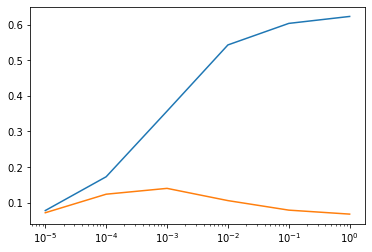

In [96]:
plt.figure()
plt.plot(c_values, train_scores, label='train')
plt.plot(c_values, test_scores, label='test')
plt.xscale('log')
plt.show

In [110]:
train_scores

[0.07767076472415782,
 0.17256224757001465,
 0.35679730149571703,
 0.5426745373041587,
 0.6031245839066175,
 0.6226532333229773]

In [111]:
test_scores

[0.0714951404606577,
 0.12355212355212356,
 0.1399281054453468,
 0.10557848488882972,
 0.07881773399014778,
 0.06763413659965384]